# Revisão da temperatura

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import mltools as ml
import temperatura as tm

## Limpeza e organização dos dados

Este processamento pode ser feito uma única vez, e o resultado do processamento é salvo em arquivos que podem ser carregados nas seções seguintes.

In [2]:
# Para salvar o resultado em arquivos:
tm.processs_leggo_data('../dados/proposicoes_processadas_2011_2021_part01/', '../dados/processed/congresso_trams_', return_df=False)

# Para retornar o resultado:
#df = tm.processs_leggo_data('../dados/proposicoes_processadas_2011_2021_part01/')

Carregando dados das proposições...
Identificando proposições com múltiplos leggo IDs...
Carregando dados de tramitações...
Existem 1 proposições na base de tramitações não listadas na base de proposições.
Juntando IDs leggo únicos à base de tramitações...
Padronizando tipo de proposição e incluindo-o nos dados...
Salvando dados processados por tipo de proposição...
Pronto!


#### Algumas anotações  sobre os dados

* Reparei que uma mesma proposição pode receber mais de um ID leggo. _Isso foi corrigido no processamento._
* **Atenção:** algumas proposições na tramitação não estão listadas na base de proposições.
* Todas as informações da coluna `situacao_descricao_situacao` estão contidas na coluna `descricao_situacao`. A última contém informações para a Câmara e para o Senao, enquanto que a primeira só contém informações para o Senado. 
* Quase todas as informações presentes na coluna `titulo_evento` estão contidas na coluna `evento`. Uma diferença é que a coluna `titulo_evento` possui, em alguns casos, campos vazios. Os poucos casos nos quais as informações são diferentes são os eventos: `transformada_em_norma_juridica` (senado); e `req_apresentacao`, `req_arquivado`, `req_deferido` e `req_indeferido` (nesses casos, o `titulo_evento` traz informações sobre o tipo de requerimento).
* Pode ser útil criar um identificador de regime de tramitação, para saber se a proposição estava num certo regime (e.g. de urgência) numa dada época. Essa informação existe apenas na base `proposicoes.csv`, congelada em algum momento do tempo.

## Carregando dados limpos e separando as amostras

Aqui nós carregamos os dados já limpos na seção anterior e os dividimos em amostras de treinamento, validação e teste.

In [3]:
# Load previously cleaned tramitações data:
tramitacoes = pd.read_csv('../dados/processed/congresso_trams_.csv', low_memory=False)
#tramitacoes = pd.read_csv('../dados/processed/congresso_trams_PL_PLC_PLS.csv', low_memory=False)
tramitacoes['data'] = pd.to_datetime(tramitacoes['data'])

In [4]:
# Split the dataset:
train_trams, val_trams, test_trams = tm.sequence_dataset_split(tramitacoes, 0.2, 'unique_id_leggo')

## Processamento dos dados

Antes de passar os dados para o modelo, eles precisam ser processados, sendo que esse processamento depende de parâmetros que podem ser alterados e podem afetar o resultado final. Esta seção contém esse processamento dos dados que possui parâmetros ajustáveis.

### Processamento inicial (um pouco demorado)

Por ser demorado, esse processamento inicial não foi incluído na pipeline de processamento dos dados.

In [5]:
# Parâmetros:
relevant_cols     = ['unique_id_leggo', 'sigla_tipo', 'casa', 'local', 'sigla_local', 'descricao_situacao', 'evento', 'titulo_evento', 'nivel', 'data', 'sequencia']
event_identifier  = ['descricao_situacao', 'evento', 'titulo_evento']
sorter_cols       = ['data', 'sequencia']   
next_days         = 14
avg_aval_timestep = 7
max_date          = '2021-03-10'
max_nivel         = 1
last_n_actions    = 3

# Process each set independently:
fixed_train_trams = tm.prepare_tramitacoes_data(train_trams, relevant_cols, event_identifier, sorter_cols, next_days, avg_aval_timestep, max_date, max_nivel, last_n_actions)
fixed_val_trams   = tm.prepare_tramitacoes_data(val_trams,   relevant_cols, event_identifier, sorter_cols, next_days, avg_aval_timestep, max_date, max_nivel, last_n_actions)
#fixed_test_trams  = tm.prepare_tramitacoes_data(test_trams,  relevant_cols, event_identifier, sorter_cols, next_days, avg_aval_timestep, max_date, max_nivel, last_n_actions)

/home/jovyan/work/analises/temperatura.py:291: FutureWarning: The default value of regex will change from True to False in a future version.
  return series.str.replace('^(?:MPV|PEC|PL|PLP)\d{4,7}', 'Comissão Especial')


### Processamento do scikit-learn

Abaixo nós criamos o pipeline de processamento dos dados. O processamento em si é feito na hora de utilizar o modelo, mais abaixo.

In [6]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
# Feature columns:
cat_cols = ['casa', 'local', 'sigla_local', 'descricao_situacao', 'evento']
num_cols = ['nivel']
log_cols = ['delta_days', 'delta_aval']

# Preprocessing for each data type:
cat_preproc = Pipeline([('enc', OneHotEncoder(categories='auto', handle_unknown='ignore'))])
num_preproc = Pipeline([('scl', MinMaxScaler())])
log_preproc = Pipeline([('log', FunctionTransformer(tm.log10_one_plus)), ('scl', StandardScaler())])

# Preprocessing:
preproc = ColumnTransformer([('cat', cat_preproc, cat_cols), ('num', num_preproc, num_cols), ('log', log_preproc, log_cols)])
#preproc = ColumnTransformer([('cat', 'passthrough', cat_cols), ('num', 'passthrough', num_cols), ('log', 'passthrough', log_cols)])
unstack = tm.UnstackSnapshots(last_n_actions)

# Full pipeline:
pipeline = Pipeline([('proc', preproc), ('unstack', unstack)])

## Modelos de Baseline

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB

In [9]:
# Preprocess data:

X_train = pipeline.fit_transform(fixed_train_trams).toarray()
y_train = tm.get_target_from_sequence_set(fixed_train_trams, ['unique_id_leggo', 'data_aval'], 'acao_futura')

X_val = pipeline.transform(fixed_val_trams).toarray()
y_val = tm.get_target_from_sequence_set(fixed_val_trams, ['unique_id_leggo', 'data_aval'], 'acao_futura')

### Modelo aleatório

In [10]:
# Random model:
random_model = ml.RandomPicker(False)
dump = random_model.fit(X_train, y_train)
y_val_pred = random_model.predict(X_val)
y_val_prob = np.ones_like(y_val_pred) * 0.5
tm.binary_classification_scores(y_val, y_val_pred, y_val_prob)

accuracy_score: 0.50123
f1_score: 0.04009
precision_score: 0.02089
recall_score: 0.49548
roc_auc_score: 0.50000


### Naive Bayes

In [11]:
# Naive Bayes:
gaussianNB = GaussianNB()
batch_size = 50000

for i in range(int(len(X_train) / batch_size + 1)):
    dump = gaussianNB.partial_fit(X_train[i*batch_size:(i+1)*batch_size], y_train.iloc[i*batch_size:(i+1)*batch_size], classes=[0, 1])

y_val_pred = gaussianNB.predict(X_val)
y_val_prob = gaussianNB.predict_proba(X_val)
tm.binary_classification_scores(y_val, y_val_pred, y_val_prob[:, 1])

accuracy_score: 0.11011
f1_score: 0.04388
precision_score: 0.02245
recall_score: 0.97139
roc_auc_score: 0.53154


## Modelo lightGBM

In [12]:
import lightgbm as lgb
import scipy as sc
from sklearn.metrics import roc_auc_score

In [13]:
# Preprocess data:

X_train = sc.sparse.csr_matrix(pipeline.fit_transform(fixed_train_trams))
y_train = tm.get_target_from_sequence_set(fixed_train_trams, ['unique_id_leggo', 'data_aval'], 'acao_futura')

X_val = sc.sparse.csr_matrix(pipeline.transform(fixed_val_trams))
y_val = tm.get_target_from_sequence_set(fixed_val_trams, ['unique_id_leggo', 'data_aval'], 'acao_futura')

# Convert to LightGBM datasets:
dataset_train = lgb.Dataset(X_train, label=y_train)
dataset_val   = lgb.Dataset(X_val, label=y_val, reference=dataset_train)

In [14]:
# Train the model:
parameters = {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.1, 'num_leaves': 40}
num_round = 20
bst = lgb.train(parameters, dataset_train, num_round)

print('Train score:', np.round(roc_auc_score(y_train, bst.predict(X_train)), 4))
print('Valid score:', np.round(roc_auc_score(y_val, bst.predict(X_val)), 4))

Train score: 0.9106
Valid score: 0.8635


## Avaliação do modelo

In [15]:
import datetime as dt
import utils as xu

In [16]:
# Compute the temperature for the validation set (apply a subjective monotonic function to the predicted probabilities):
temp_val = (2.8 + np.log10(bst.predict(X_val))) / 2.8 * 100

# Build a DataFrame of proposições, assessment dates and temperatures:
temp_predictions_val = fixed_val_trams[['unique_id_leggo', 'data_aval']].drop_duplicates().reset_index(drop=True)
temp_predictions_val['temperatura'] = pd.Series(temp_val)
temp_predictions_val['acao_futura'] = pd.Series(y_val.values)
temp_predictions_val = temp_predictions_val.sort_values('temperatura', ascending=False)

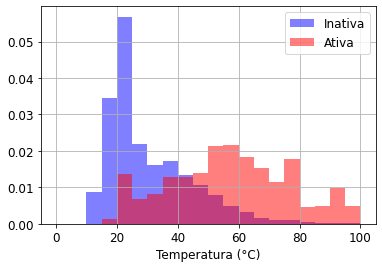

In [17]:
# Plot the probability distribution of the temperature for proposições with some action in the near function and for those without any action in the near future: 
dtemp = 5
temp_edges = np.arange(0, 100 + dtemp, dtemp)
temp_predictions_val.loc[temp_predictions_val['acao_futura'] == 0, 'temperatura'].hist(bins=temp_edges, density=True, alpha=0.5, color='b', label='Inativa')
temp_predictions_val.loc[temp_predictions_val['acao_futura'] == 1, 'temperatura'].hist(bins=temp_edges, density=True, alpha=0.5, color='r', label='Ativa')
pl.xlabel('Temperatura (°C)', fontsize=12)
pl.tick_params(labelsize=12)
pl.legend(fontsize=12)
pl.show()

### Análise de exemplos

Vamos analisar exemplos individuais, verificando o histórico da proposição, sua temperatura e o que acontece logo depois.

In [18]:
# Selecione um exemplo entre os ordenados da maior para a menor temperatura:
i = 40

# Imprime características do exemplo:
print(xu.Bold('Características do exemplo'))
print('Haverá ação em breve:', temp_predictions_val['acao_futura'].iloc[i])
print('Temperatura:', np.round(temp_predictions_val['temperatura'].iloc[i], 1))
data_aval = temp_predictions_val['data_aval'].iloc[i]
print('Data aval.:', data_aval.date())

# Imprime histórico de tramitação até a data de avaliação:
ex_id = temp_predictions_val['unique_id_leggo'].iloc[i]
example_trams = val_trams.loc[(val_trams['unique_id_leggo'] == ex_id), relevant_cols].sort_values('data')
print('')
print(xu.Bold('Histórico'))
example_trams.loc[example_trams['data'] <= data_aval].tail(10)


Características do exemplo
Haverá ação em breve: 1
Temperatura: 95.9
Data aval.: 2019-06-11

Histórico


,unique_id_leggo,sigla_tipo,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,data,sequencia
49312,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,NaN,NaN,4,2019-05-22 00:00:00+00:00,6
49313,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-05-24 14:44:00+00:00,7
49314,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-05-24 14:44:00+00:00,8
49316,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,NaN,NaN,4,2019-05-24 14:46:00+00:00,10
49315,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,distribuicao,Distribuição,3,2019-05-24 14:46:00+00:00,9
49317,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-05-24 16:13:00+00:00,11
49318,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,CCP,NaN,NaN,NaN,4,2019-05-24 16:30:00+00:00,12
49319,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,CCP,NaN,NaN,NaN,4,2019-05-27 00:00:00+00:00,14
49320,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,CCP,NaN,NaN,NaN,4,2019-05-27 10:56:00+00:00,13
49321,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,recebido_por_comissao,Recebido por Comissão,2,2019-05-28 17:21:00+00:00,15


In [19]:
# Imprime os eventos seguintes à data de avaliação:
print(xu.Bold('Futuro'))
example_trams.loc[(example_trams['data'] > data_aval) & (example_trams['data'] <= data_aval + dt.timedelta(days=180))]

Futuro


,unique_id_leggo,sigla_tipo,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,data,sequencia
49322,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,designado_relator,Designação de Relator,1,2019-06-19 00:00:00+00:00,16
49323,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,inicio_prazo_emendas,Início do Prazo para Emendas,3,2019-06-21 00:00:00+00:00,17
49324,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,fim_prazo_emendas,Fim do Prazo para Emendas,3,2019-07-04 13:03:00+00:00,18
49325,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,NaN,NaN,4,2019-08-20 13:46:00+00:00,19
49326,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,parecer_pela_aprovacao,Parecer pela Aprovação,2,2019-08-20 13:46:00+00:00,20
49327,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,NaN,NaN,4,2019-08-28 10:00:00+00:00,21
49328,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,designado_relator,Designação de Relator,1,2019-09-04 00:00:00+00:00,24
49329,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,NaN,NaN,4,2019-09-04 00:00:00+00:00,25
49330,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,NaN,NaN,4,2019-09-04 10:00:00+00:00,22
49331,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CAPADR,CAPADR,NaN,designado_relator,Designação de Relator,1,2019-09-04 10:36:00+00:00,23


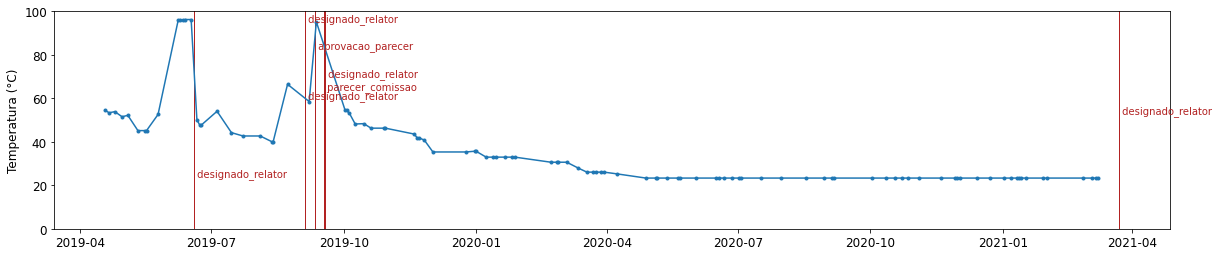

In [20]:
# Plot da evolução da temperarura ao longo do tempo para a proposição selecionada, junto com eventos muito importantes:

pl.figure(figsize=(20,4))

# Seleciona eventos importantes:
landmarks = example_trams.loc[example_trams['nivel'] == 1]
# Coloca os eventos importantes no gráfico:
for j in range(len(landmarks)):
    pl.axvline(landmarks.iloc[j]['data'], linewidth=1, color='firebrick')
    pl.text(landmarks.iloc[j]['data'], np.random.normal(70, 20), ' ' + landmarks.iloc[j]['evento'], color='firebrick')
# Plota a temperatura ao longo do tempo:
ex_temps = temp_predictions_val.loc[temp_predictions_val['unique_id_leggo'] == ex_id].sort_values('data_aval')
pl.plot(ex_temps['data_aval'], ex_temps['temperatura'], marker='.')
# Formata:
pl.tick_params(labelsize=12)
pl.ylabel('Temperatura (°C)', fontsize=12)
pl.ylim(0,100)
pl.show()

In [21]:
# Toda a tramitação da proposição:
example_trams#.iloc[180:230]

,unique_id_leggo,sigla_tipo,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,data,sequencia
49307,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,PLEN,NaN,apresentacao_pl,Apresentação de Projeto de Lei,3,2019-04-16 17:41:00+00:00,1
49308,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SEPRO,NaN,NaN,NaN,4,2019-04-16 17:41:00+00:00,2
49309,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,CEDI,NaN,NaN,NaN,4,2019-04-16 17:41:00+00:00,3
49310,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SEPRO,NaN,NaN,NaN,4,2019-04-17 11:07:00+00:00,4
49311,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-04-17 11:29:00+00:00,5
49312,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,NaN,NaN,4,2019-05-22 00:00:00+00:00,6
49313,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-05-24 14:44:00+00:00,7
49314,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,SECAP(SGM),NaN,NaN,NaN,4,2019-05-24 14:44:00+00:00,8
49316,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,NaN,NaN,4,2019-05-24 14:46:00+00:00,10
49315,f63a501a886b2b45358125ddbe7f13fb,PL,camara,CD-MESA-PLEN,MESA,NaN,distribuicao,Distribuição,3,2019-05-24 14:46:00+00:00,9
